In [3]:
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment','raise')
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
ox_vax = pd.read_csv('ox_astra_cov002.csv')
ox_vax

,Dose,Group,N,Cases
0,LD,Control,1374,30
1,LD,Covax,1367,3
2,SD,Control,2430,38
3,SD,Covax,2377,15


In [5]:
c19_cases = sum(ox_vax['Cases'])
total_pop = sum(ox_vax['N'])
prop_covid = c19_cases/total_pop
prop_covid

0.011393746687864335

In [6]:
def calc_prop_cases(df):
    cases_df=sum(df['Cases'])
    n_df = sum(df['N'])
    prop = cases_df / n_df
    return prop
calc_prop_cases(ox_vax)

0.011393746687864335

In [7]:
vax_eff = 1 - calc_prop_cases(ox_vax)
vax_eff

0.9886062533121357

In [8]:
def calc_efficiency(df):
    RR = calc_prop_cases(df)
    vax_eff = 1 - RR
    return vax_eff
calc_efficiency(ox_vax)

0.9886062533121357

In [9]:
ld_vax_eff = calc_efficiency(ox_vax[ox_vax['Dose'].isin(['LD'])])
sd_vax_eff = calc_efficiency(ox_vax[ox_vax['Dose'].isin(['SD'])])
vax_eff_diff = ld_vax_eff - sd_vax_eff
print('LD efficiency', ld_vax_eff)
print('SD efficiency', sd_vax_eff)
print('Efficiency difference', vax_eff_diff)

LD efficiency 0.9879605983217804
SD efficiency 0.9889744123153734
Efficiency difference -0.0010138139935930157


In [10]:
def calc_ld_sd_ediff(df):
    ld_vax_eff = calc_efficiency(df[df['Dose'].isin(['LD'])])
    sd_vax_eff = calc_efficiency(df[df['Dose'].isin(['SD'])])
    vax_eff_diff = ld_vax_eff - sd_vax_eff
    return vax_eff_diff
calc_ld_sd_ediff(ox_vax)

-0.0010138139935930157

In [11]:
person_start = pd.DataFrame()
person_start['Dose'] = np.repeat(['LD'], [5])
person_start['Group'] = np.repeat(['Control'], [5])
person_start['Case'] = np.repeat(['False','True'], [3,2])
person_start

,Dose,Group,Case
0,LD,Control,False
1,LD,Control,False
2,LD,Control,False
3,LD,Control,True
4,LD,Control,True


In [12]:
person_df = pd.DataFrame()
n_per_cell = np.array(ox_vax['N'])
person_df['Dose'] = np.repeat(['LD', 'LD', 'SD', 'SD'], n_per_cell)
# Show the first five rows
person_df.head()

,Dose
0,LD
1,LD
2,LD
3,LD
4,LD


In [13]:
person_df['Group'] = np.repeat(['Control', 'Covax', 'Control', 'Covax'], n_per_cell)
person_df.head()

,Dose,Group
0,LD,Control
1,LD,Control
2,LD,Control
3,LD,Control
4,LD,Control


In [14]:
# Run this cell.
# "Case" will be False for non-case, True for case.
# Start with all False
to_repeat = np.repeat([False], len(n_per_cell) * 2)
# Set every other value, from the second, to True
to_repeat[1:len(to_repeat):2] = True
# Note that we can do the same thing with this short-cut.
to_repeat[1::2] = True
# Show the result
to_repeat

array([False,  True, False,  True, False,  True, False,  True])

In [15]:
repeat_nos = np.repeat([0], len(to_repeat))
case_per_cell = np.array(ox_vax['Cases'])
false_repeat = n_per_cell- case_per_cell
repeat_nos[::2]= false_repeat
repeat_nos[1::2] = case_per_cell
person_df['Case'] = np.repeat(to_repeat, repeat_nos)
person_df.head()

,Dose,Group,Case
0,LD,Control,False
1,LD,Control,False
2,LD,Control,False
3,LD,Control,False
4,LD,Control,False


In [16]:
# Make a thing that knows how to "group" the rows "by" the pairs of labels in
# "Dose" and "Group".
grouped = person_df.groupby(['Dose', 'Group'])
# Aggregate within these groups, by
# * counting the number of rows
# (put this value into the column "N")
# * counting the number of True values in the "Case" column
# (put this value into the column "Cases")
aggregated = grouped.agg(N=('Case', len),Cases=('Case', np.count_nonzero))
# Drop the fancy index (row labels) to make an ordinary data frame.
tabulated = aggregated.reset_index()
tabulated

,Dose,Group,N,Cases
0,LD,Control,1374,30
1,LD,Covax,1367,3
2,SD,Control,2430,38
3,SD,Covax,2377,15


In [17]:
def cases_to_counts(full_df):
    grouped = full_df.groupby(['Dose', 'Group'])
    return full_df.groupby(['Dose', 'Group']).agg(N=('Case', len),Cases=('Case', np.count_nonzero)).reset_index()
cases_to_counts(person_df)

,Dose,Group,N,Cases
0,LD,Control,1374,30
1,LD,Covax,1367,3
2,SD,Control,2430,38
3,SD,Covax,2377,15


In [18]:
cases_to_counts(person_df).equals(ox_vax)

True

In [19]:
fake_df = person_df.copy()
fake_df['Dose'] = np.random.permutation(person_df['Dose'])
fake_df.head()

,Dose,Group,Case
0,LD,Control,False
1,SD,Control,False
2,LD,Control,False
3,SD,Control,False
4,LD,Control,False


In [20]:
n_iters = 1000
fake_ediffs=[]
for i in range(n_iters):
    fake_df['Dose'] = np.random.permutation(person_df['Dose'])
    fake_orignal = cases_to_counts(fake_df)
    fake_ediffz = calc_ld_sd_ediff(fake_orignal)
    fake_ediffs.append(fake_ediffz)
# Show the first 10 efficiency differences.
fake_ediffs[:10]

[0.0007047669370043863,
 0.0012776272472035943,
 -0.0010138139935930157,
 -0.0027323949241905288,
 -0.0015866743037922237,
 0.0007047669370043863,
 0.0012776272472035943,
 -0.0010138139935930157,
 -0.0027323949241905288,
 0.0007047669370043863]

(array([ 53., 412., 481.,  54.]),
 array([-0.00788814, -0.00402133, -0.00015452,  0.00371228,  0.00757909]),
 <BarContainer object of 4 artists>)

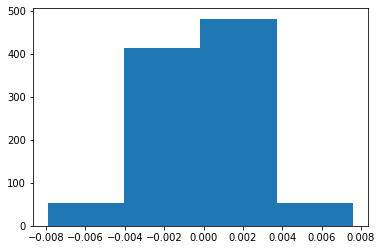

In [21]:
plt.hist(fake_ediffs,bins=4)

In [22]:
count = 0
for i in range(len(fake_ediffs)):
    if i >= -0.0010138139935930157:
        count += 1
prop_ediff_ge = (len(fake_ediffs)/ count)
# Show the result
prop_ediff_ge

1.0